In [ ]:
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/IMDB Dataset.csv")
print(df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [ ]:
import os
import io
import string
from tqdm import tqdm
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
data['sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})

In [ ]:
# Shuffle the DataFrame
shuffled_data = data.sample(frac=1, random_state=2023)

train_size = 0.8  # 80% for training, 20% for testing
train_data, test_data = train_test_split(shuffled_data, train_size=train_size, random_state=2023)

In [ ]:
print(f'Train shappe: {train_data.shape}')
print(f'Test shappe: {test_data.shape}')

Train shappe: (40000, 2)
Test shappe: (10000, 2)


In [ ]:
X_train = train_data['review']
y_train = train_data['sentiment']

X_test = test_data['review']
y_test = test_data['sentiment']

In [ ]:
# using stopwords from nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
table = str.maketrans('', '', string.punctuation)

In [ ]:
X_train_cleaned = []

for item in tqdm(X_train):
    sentence = str(item).lower()
    # if we have 2 joined words
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    # remove <br> tag
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    # remove stop words and punctuations
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table) # remove all punctuations
        if word not in stop_words:
            filtered_sentence += word + ' '

    X_train_cleaned.append(filtered_sentence.strip())

  2%|▏         | 855/40000 [00:02<02:00, 324.79it/s]<ipython-input-15-07e5d7fdea4c>:11: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(sentence)
100%|██████████| 40000/40000 [00:39<00:00, 1015.61it/s]


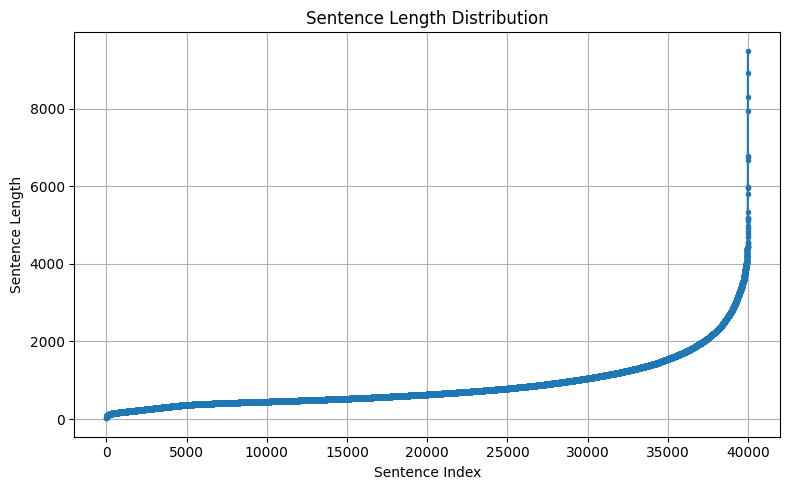

In [ ]:
sentence_lengths = [len(sentence) for sentence in X_train_cleaned]
sorted_lengths = sorted(sentence_lengths)

x_values = list(range(1, len(X_train_cleaned) + 1))

# Creiamo il grafico
plt.figure(figsize=(8, 5))
plt.plot(x_values, sorted_lengths, marker='.', linestyle='-')
plt.title('Sentence Length Distribution')
plt.xlabel('Sentence Index')
plt.ylabel('Sentence Length')
plt.grid(True)
plt.tight_layout()
plt.show()

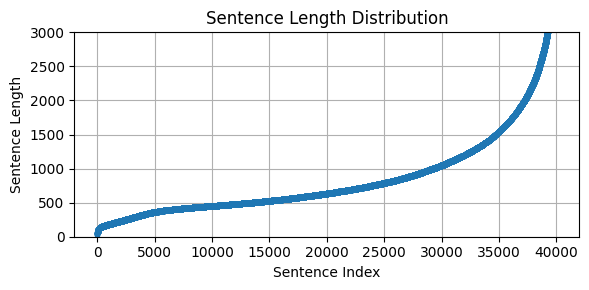

In [ ]:
# Creiamo il grafico
plt.figure(figsize=(6, 3))
plt.plot(x_values, sorted_lengths, marker='.', linestyle='-')
plt.title('Sentence Length Distribution')
plt.xlabel('Sentence Index')
plt.ylabel('Sentence Length')
plt.grid(True)
plt.tight_layout()
plt.ylim(0, 3000)
plt.show()

In [ ]:
all_words = [word for sentence in X_train_cleaned for word in sentence.split()]

# Calculate the vocabulary size (number of unique words)
total_vocab_size = len(set(all_words))

print("Total Vocabulary Size:", total_vocab_size)

Total Vocabulary Size: 110111


In [ ]:
vocab_size = 50000
max_length = 2000
trunc_type='post'
padding_type='post'
oov_tok = ""

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train_cleaned)

In [ ]:
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(X_train_cleaned)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white')

# Generate the word cloud
word_counts = tokenizer.word_counts
wordcloud.generate_from_frequencies(word_counts)
wordcloud.to_file("doc/header.png")

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/doc/header.png'

In [ ]:
training_padded, validation_padded, y_train, y_valid = train_test_split(training_padded, y_train, test_size=0.2, random_state=2023)

In [ ]:
training_padded = np.array(training_padded)
training_labels = np.array(y_train)

validation_padded = np.array(validation_padded)
validation_labels = np.array(y_valid)

testing_padded = np.array(testing_padded)
testing_labels = np.array(y_test)

In [ ]:
print(f'Train shappe: {train_data.shape}')
print(f'Validation shappe: {validation_padded.shape}')
print(f'Test shappe: {test_data.shape}')

Train shappe: (40000, 2)
Validation shappe: (8000, 2000)
Test shappe: (10000, 2)


In [ ]:
embedding_dim = round(vocab_size ** 0.25) # use the fourth root of the vocab size
l2_regularization = 0.01 # tends to amplify differences between nonzero values and zero or close-tozero ones

In [ ]:
def create_model(vocab_size, embedding_dim):
    model = tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, embedding_dim), # turns positive integers into dense vectors of fixed size
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(24, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)),
            tf.keras.layers.Dropout(.25),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

    adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model

In [ ]:
model = create_model(vocab_size, embedding_dim)
# Display the model's architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Import the necessary callback
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback
# This saves the model at the end of each epoch
# and uses validation accuracy to choose best model.
cp_callback = ModelCheckpoint(
    filepath='model_checkpoint.keras',  # Changed the file extension to .keras
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Now you can use cp_callback in model.fit:
num_epochs = 10
history = model.fit(training_padded,
                    training_labels,
                    epochs=num_epochs,
                    validation_data=(validation_padded, validation_labels),
                    verbose=2,
                    callbacks=[cp_callback])

Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.50225, saving model to model_checkpoint.keras
1000/1000 - 17s - 17ms/step - accuracy: 0.5036 - loss: 0.7023 - val_accuracy: 0.5023 - val_loss: 0.6975
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.50225
1000/1000 - 18s - 18ms/step - accuracy: 0.5038 - loss: 0.6954 - val_accuracy: 0.4979 - val_loss: 0.6940
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.50225
1000/1000 - 20s - 20ms/step - accuracy: 0.5049 - loss: 0.6936 - val_accuracy: 0.4979 - val_loss: 0.6933
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.50225
1000/1000 - 17s - 17ms/step - accuracy: 0.5012 - loss: 0.6932 - val_accuracy: 0.4979 - val_loss: 0.6932
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.50225
1000/1000 - 17s - 17ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.4979 - val_loss: 0.6932
Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.50225
1000/1000 - 20s - 20ms/step - accuracy: 0.5009 - loss: 0.6932

In [ ]:
import os

# Before saving the model, create the directory if it doesn't exist
os.makedirs('model', exist_ok=True)

# Now save the model
model.save('model/sentiment_model_v1.keras') # Added .keras extension

In [ ]:
def plot_history(history, name):
  plt.plot(history.history[name])
  plt.plot(history.history['val_'+name])
  plt.xlabel("Epochs")
  plt.ylabel(name)
  plt.legend([name, 'val_'+name])
  plt.show()

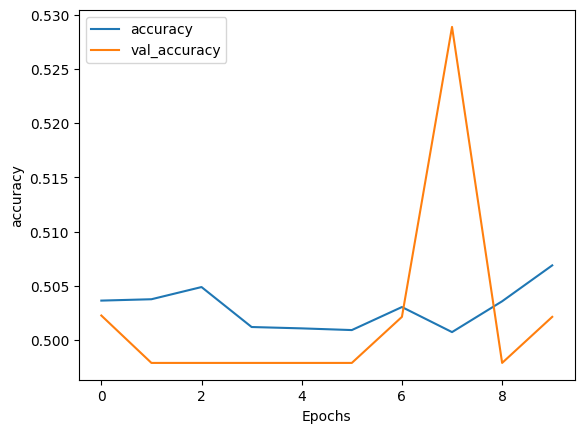

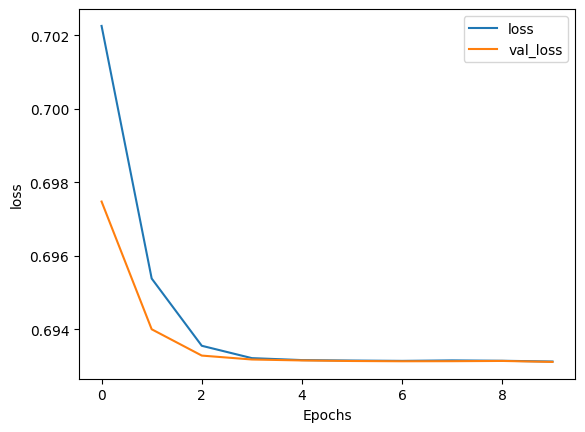

In [ ]:
plot_history(history, "accuracy")
plot_history(history, "loss")

In [ ]:
model.evaluate(testing_padded, testing_labels, verbose=2)

313/313 - 1s - 4ms/step - accuracy: 0.5050 - loss: 0.6931


[0.693120002746582, 0.5049999952316284]

In [ ]:
sentences = ["I recently watched it, and it's absolutely fantastic. The acting, direction, and storytelling are all top-notch. I highly recommend it.",
             "I watched it and was let down. The acting felt flat, and the story was uninspiring. I wouldn't recommend it."]
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
[[0.4987706 ]
 [0.49876633]]


In [ ]:
import os
import io

# Before writing to the files, create the 'data' directory if it doesn't exist
os.makedirs('data', exist_ok=True)

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
e = model.layers[0]
weights = e.get_weights()[0]
out_v = io.open('data/vector.tsv', 'w', encoding='utf-8')
out_m = io.open('data/metadata.tsv', 'w', encoding='utf-8')

for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")

out_v.close()
out_m.close()